# TP3 - Clasificación de cancer de mama

En este trabajo practico vamos a analizar un dataset de cancer de mama y vamos a clasificar los datos en benignos o malignos

Integrantes: Franco Bertoldi y Augusto Mancuso

In [644]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from sklearn.datasets import load_breast_cancer

Descargamos el dataset de cancer de mama y dividimos en features y target

In [645]:
data = load_breast_cancer()
features = pd.DataFrame(data.data, columns=data.feature_names)
target = pd.DataFrame(data.target, columns=['target'])

In [646]:
features.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Al analizar las feautures vemos que hay columnas de medias, errores y peores valores. 

In [647]:
# Beningo es 1 y maligno es 0
target.head()

,target
0,0
1,0
2,0
3,0
4,0


Vamos a analizar la correlacion de las features con el target

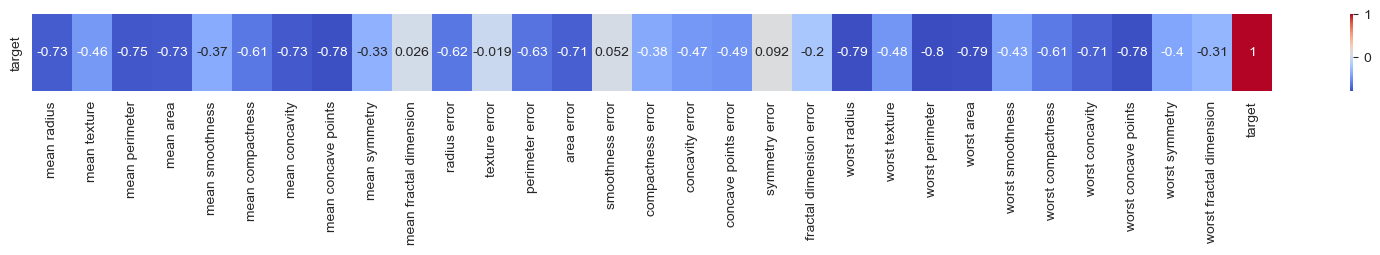

In [648]:
data = pd.concat([features, target], axis=1)
correlation = data.corr(method='spearman')
plt.figure(figsize=(20, 1))
sns.heatmap(correlation.loc[['target']], annot=True, cmap='coolwarm')
plt.show()

Nos quedamos con las features del grupo de las medias que mejor se correlacionan con el target

In [649]:
worst_case_df = features[['worst concave points', 'worst perimeter', 'worst area']]
worst_case_df.head()

,worst concave points,worst perimeter,worst area
0,0.2654,184.60,2019.0
1,0.1860,158.80,1956.0
2,0.2430,152.50,1709.0
3,0.2575,98.87,567.7
4,0.1625,152.20,1575.0


Nos quedamos con las features del grupo de los peores casos que mejor se correlacionan con el target

In [650]:
mean_df = features[['mean concave points', 'mean perimeter', 'mean area']]
mean_df.head()

,mean concave points,mean perimeter,mean area
0,0.14710,122.80,1001.0
1,0.07017,132.90,1326.0
2,0.12790,130.00,1203.0
3,0.10520,77.58,386.1
4,0.10430,135.10,1297.0


Vemos como es la distribución muestral de los datos

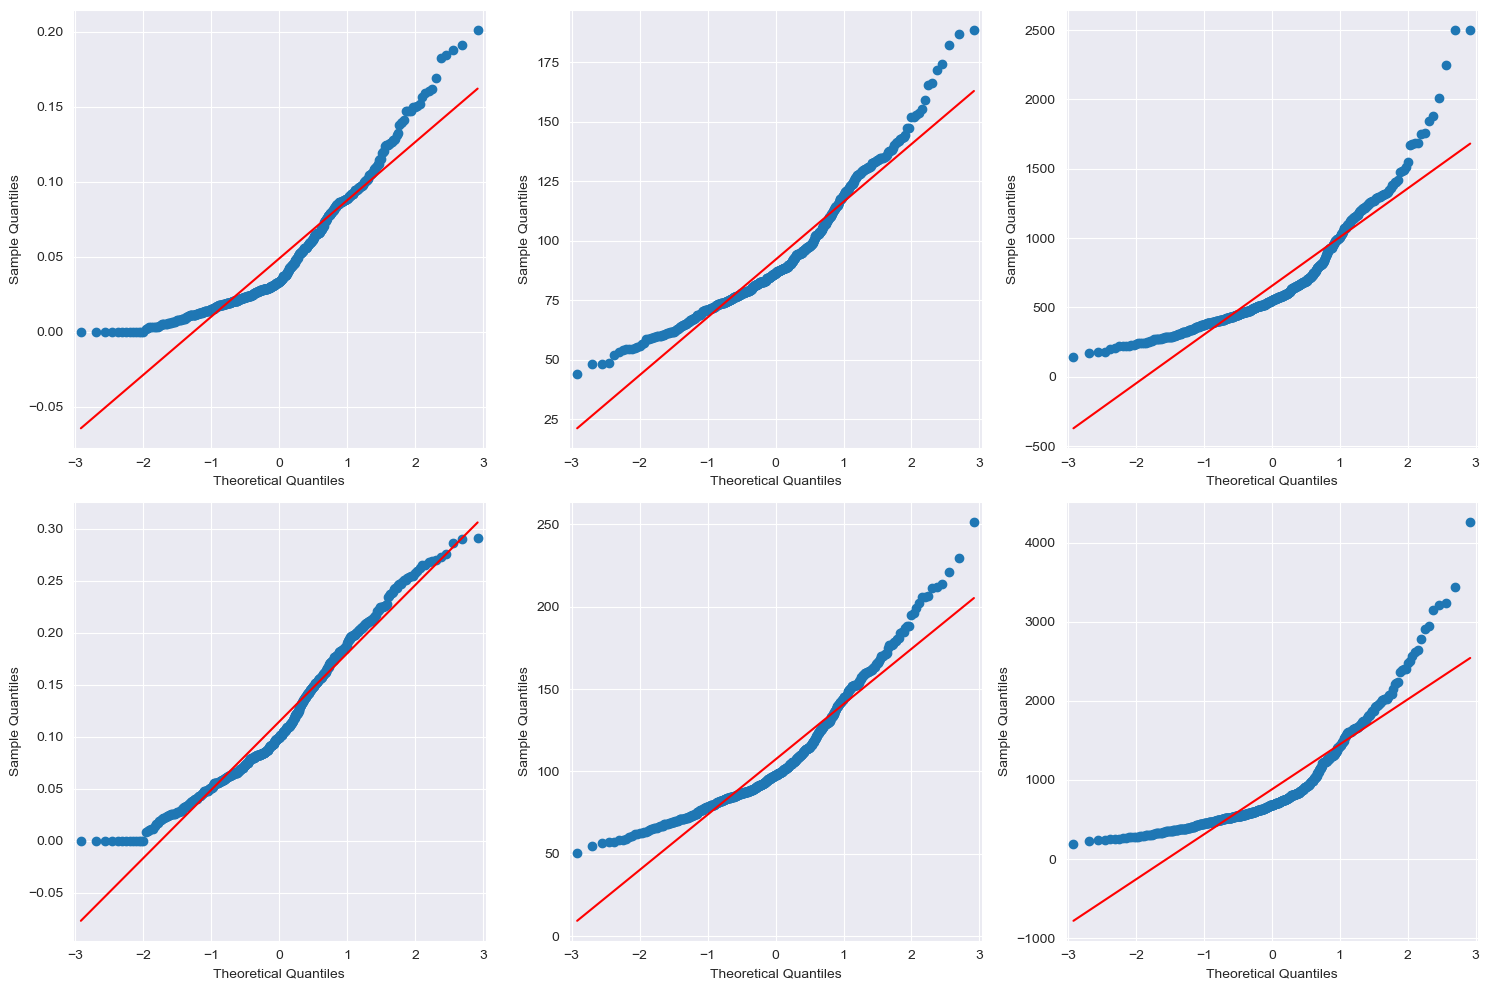

In [651]:
data = pd.concat([mean_df, worst_case_df], axis=1)

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, column in enumerate(data.columns):
    row = i // 3
    col = i % 3
    qqplot(data[column], line='s', ax=ax[row, col])
plt.tight_layout()
plt.show()

Vemos que las features no tienen mucha similitud con una distribución normal. Ahora vamos a hacer un analisis de outliers

In [652]:
outliers = pd.DataFrame(columns=['feature', 'outliers_bajo', 'outliers_alto', 'total_outliers'])

# Funcion para contar outliers
def count_outliers(df, column, factor=1.5):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr

    # Count outliers
    outliers_bajo = df[df[column] < lower_bound].shape[0]
    outliers_alto = df[df[column] > upper_bound].shape[0]
    total_outliers = outliers_bajo + outliers_alto

    return outliers_bajo, outliers_alto, total_outliers

outliers_list = []

for column in worst_case_df.columns:
    outliers_bajo, outliers_alto, total_outliers = count_outliers(worst_case_df, column)
    outliers_list.append({'feature': column, 'outliers_bajo': outliers_bajo, 'outliers_alto': outliers_alto, 'total_outliers': total_outliers})

for column in mean_df.columns:
    outliers_bajo, outliers_alto, total_outliers = count_outliers(mean_df, column)
    outliers_list.append({'feature': column, 'outliers_bajo': outliers_bajo, 'outliers_alto': outliers_alto, 'total_outliers': total_outliers})

outliers = pd.DataFrame(outliers_list)

outliers

,feature,outliers_bajo,outliers_alto,total_outliers
0,worst concave points,0,0,0
1,worst perimeter,0,15,15
2,worst area,0,35,35
3,mean concave points,0,10,10
4,mean perimeter,0,13,13
5,mean area,0,25,25


In [653]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
data_scaled = scaler.fit_transform(data)

data_no_outliers = pd.DataFrame(data_scaled, columns=data.columns)

Usamos RobustScalar de skcikit-learn para escalar los datos. Ahora vamos a probar 4 metodos para clasificar los datos:

- Regresión Logística
- KNN
- SVM
- Decision Tree
- Random Forest

Dividimos los datos entre train y test

In [654]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(data_no_outliers, target, test_size=0.2, random_state=42)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()


# SVM

In [655]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9736842105263158
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        43
           1       0.96      1.00      0.98        71

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


# KNN

In [656]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

KNN Accuracy: 0.956140350877193
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        43
           1       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


# Decision Tree

In [657]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.956140350877193
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        43
           1       0.97      0.96      0.96        71

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114


# Random Forest

In [658]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.956140350877193
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        43
           1       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


# Regresión Logística

In [659]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.9824561403508771
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        43
           1       0.99      0.99      0.99        71

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


Comparamos los resultados de los 5 modelos

In [660]:
models = ['SVM', 'KNN', 'Decision Tree', 'Random Forest', 'Logistic Regression']
accuracies = [accuracy_score(y_test, y_pred_svm), accuracy_score(y_test, y_pred_knn), accuracy_score(y_test, y_pred_dt), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_lr)]

comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies
})

comparison_df

,Model,Accuracy
0,SVM,0.973684
1,KNN,0.956140
2,Decision Tree,0.956140
3,Random Forest,0.956140
4,Logistic Regression,0.982456


Vemos que el mejor modelo es Logistc Regression. Vamos a optimizar los hiperparametros con GridSearchCV

In [661]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter': [100, 200, 300]
}

logreg = LogisticRegression(random_state=42)

grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params_ = grid_search.best_params_
print("Best Parameters:", best_params_)

best_logreg = LogisticRegression(**best_params_, random_state=42)
best_logreg.fit(X_train, y_train)

y_pred_best_logreg = best_logreg.predict(X_test)
print("Optimized Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_best_logreg))
print(classification_report(y_test, y_pred_best_logreg))

Best Parameters: {'C': 10, 'max_iter': 100, 'solver': 'newton-cg'}
Optimized Logistic Regression Accuracy: 0.9824561403508771
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        43
           1       0.99      0.99      0.99        71

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



Podemos concluir lo siguiente:

- Los mejores features para clasificar los datos son 'mean concave points', 'mean perimeter', 'mean area', 'worst concave points', 'worst perimeter', 'worst area'
- Los datos en general no tienen una distribución normal por lo que no permite el uso de Naive Bayes y LDA
- Los datos tienen outliers por lo que se uso RobustScaler para escalar los datos
- El mejor modelo para clasificar los datos es Logistic Regression
- La mejor combinacion de hiperparametros para el modelo de Logistic Regression es: {'C': 10, 'max_iter': 100, 'solver': 'newton-cg'}